In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt

from sklearn import preprocessing

Question: Describe to me how you would test statistically for a long-run relationship and what pitfalls will you be looking out for in the results, and how might you remedy these pitfalls?
gdp and inflation

In [2]:
#let's pull 10Y worth of US GDP and US inflation data
end = dt.datetime.today()
start = dt.datetime(end.year - 10, end.month, end.day)
print(start, end)

2011-05-26 00:00:00 2021-05-26 03:13:15.826444


we will pull US GDP and CPI inflation from FRED (Federal Reserve of St. Louis data)

Gross Domestic Product: Billions of Dollars, Seasonally Adjusted Annual Rate (Quarterly)

CPI: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (Index 1982-1984=100,
Seasonally Adjusted, (Monthly))

In [3]:
cpi = web.DataReader("CPIAUCSL", "fred", start, end)
gdp = web.DataReader("GDP", "fred", start, end)

let's plot these to see how it will look, we can't plot them on top of each other because they use
different indexes and prices so they will look spread out, this is what it would look like

Text(0.5, 1.0, "plotting GDP vs CPI (Don't do this)")

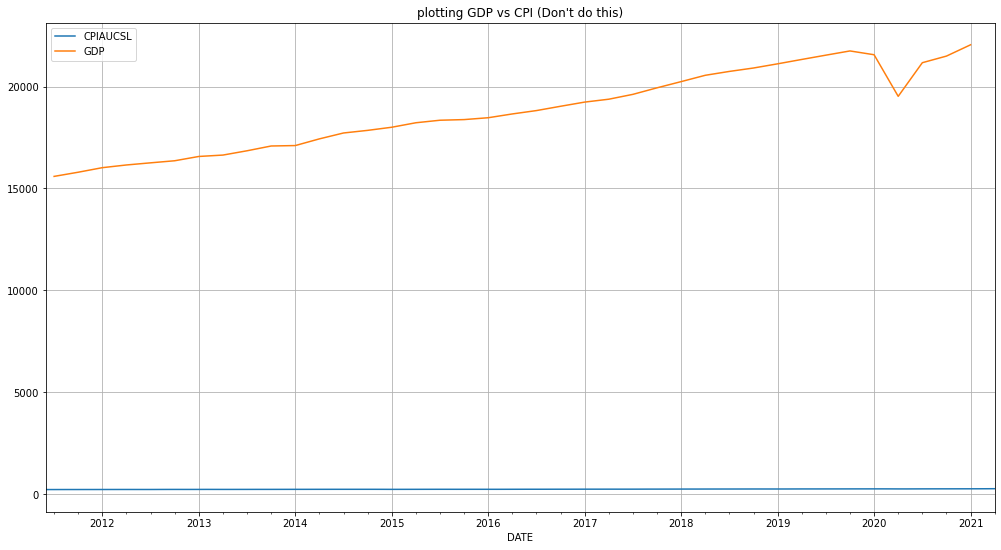

In [4]:
ax = cpi.plot()
gdp.plot(ax=ax, figsize = (17,9))
plt.grid(True)
plt.title("plotting GDP vs CPI (Don't do this)")

let's break up the plots 

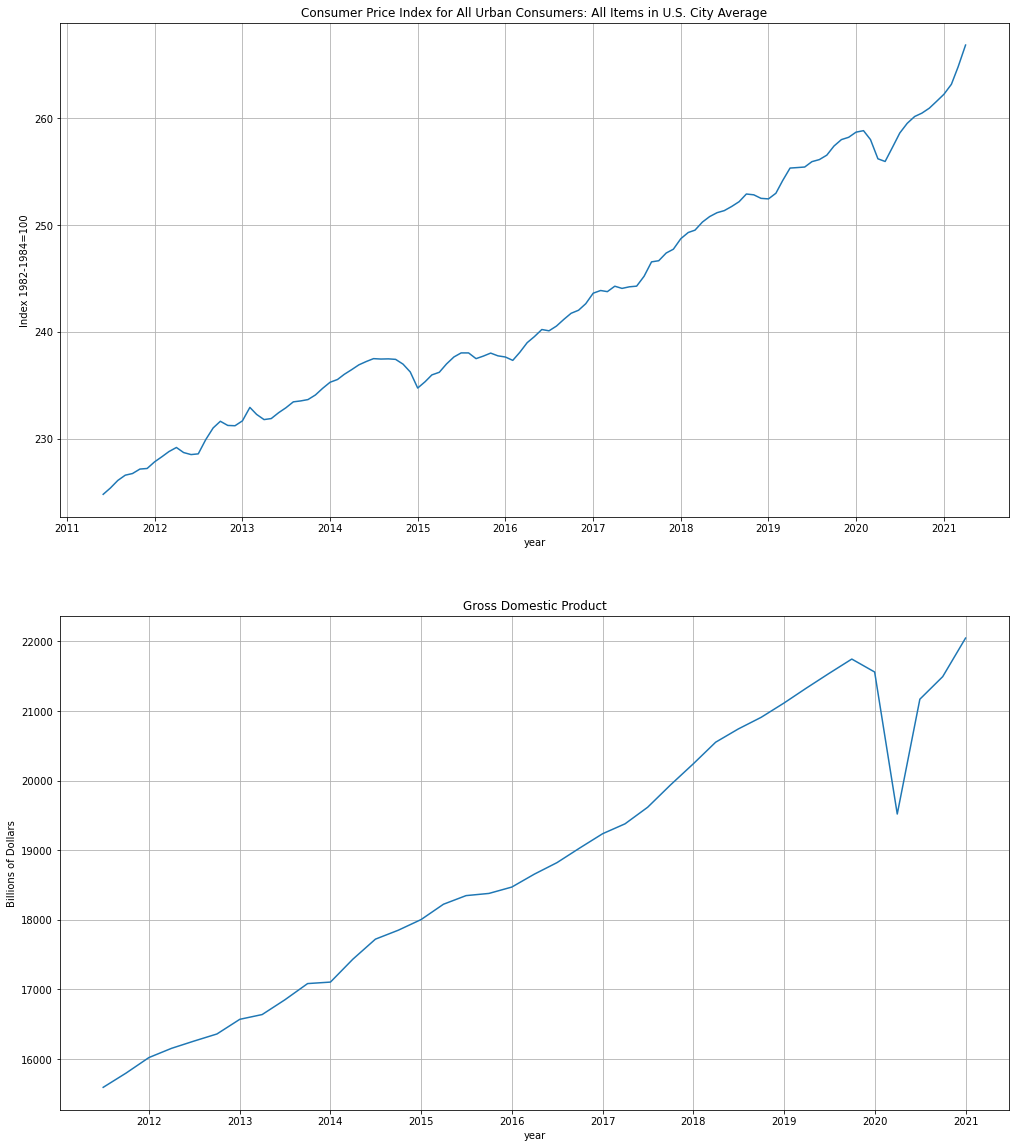

In [5]:
fig, axs = plt.subplots(2,1, figsize = (17,20))
axs[0].plot(cpi)
axs[0].set_title("Consumer Price Index for All Urban Consumers: All Items in U.S. City Average")
axs[0].set_xlabel("year")
axs[0].set_ylabel("Index 1982-1984=100")
axs[0].grid(True)

axs[1].plot(gdp)
axs[1].set_title("Gross Domestic Product")
axs[1].set_xlabel("year")
axs[1].set_ylabel("Billions of Dollars")
axs[1].grid(True)

Another idea would be to scale one of the time series to match the other or both. That should not be done because be scaling the data will make the peaks and trophs greater or smaller which will mess with the correlation. 

In [6]:
#if we normalize the data between 0 and 1

#create preprocessing scaling data
scaler = preprocessing.MinMaxScaler()

#For CPI
cpi_scaled = scaler.fit_transform(cpi)
cpi_scaled = pd.DataFrame(cpi_scaled, columns = ["CPIAUCSL"])
cpi_scaled.index = cpi.index

#for GDP
gdp_scaled = scaler.fit_transform(gdp)
gdp_scaled = pd.DataFrame(gdp_scaled, columns = ['gdp_scaled'])
gdp_scaled.index = gdp.index

Text(0.5, 1.0, "plotting GDP vs CPI scaled (Don't do this)")

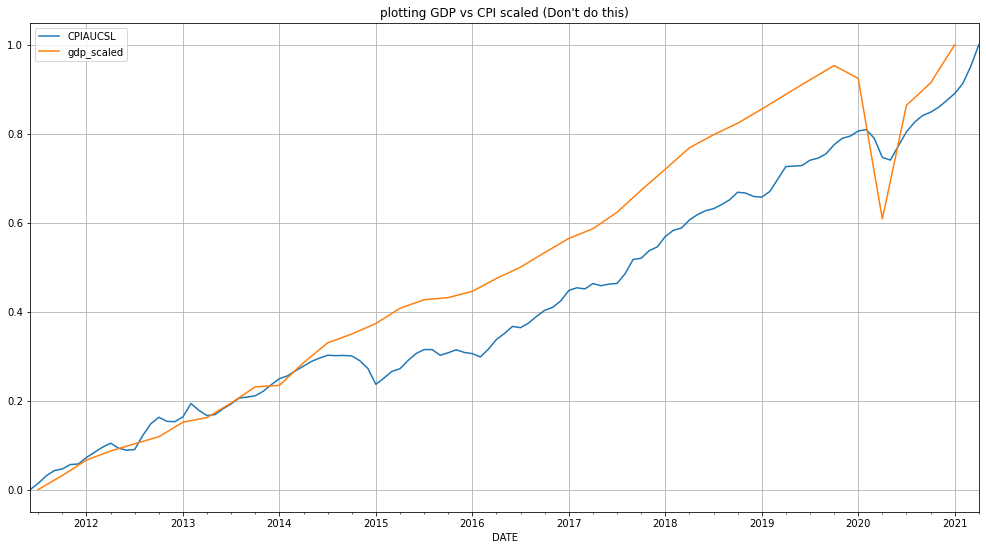

In [7]:
ax = cpi_scaled.plot()
gdp_scaled.plot(ax=ax, figsize = (17,9))
plt.grid(True)
plt.title("plotting GDP vs CPI scaled (Don't do this)")

The reason why this doesn't work is that it scales the peaks and trophs, we can see that scaling effect if we compare the returns of the scaled vs non-scaled. Many people tend to scale data for viewing purposes, it is commonly used in machine learning for deep neural networks, but in this case it shouldn't be applied. 

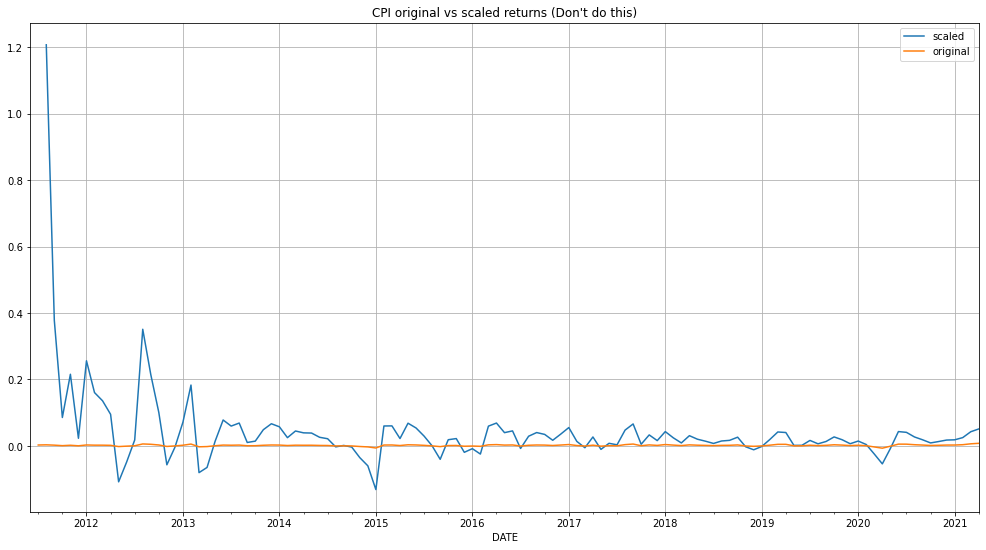

In [8]:
cpi_scaled['pct_change'] = cpi_scaled.pct_change().dropna()
cpi['pct_change'] = cpi['CPIAUCSL'].pct_change().dropna()

cpi_returns = pd.DataFrame()
cpi_returns['scaled'] = cpi_scaled['pct_change']
cpi_returns['original'] = cpi['pct_change'] 
cpi_returns.plot(figsize = (17,9), title = "CPI original vs scaled returns (Don't do this)")
plt.grid(True)

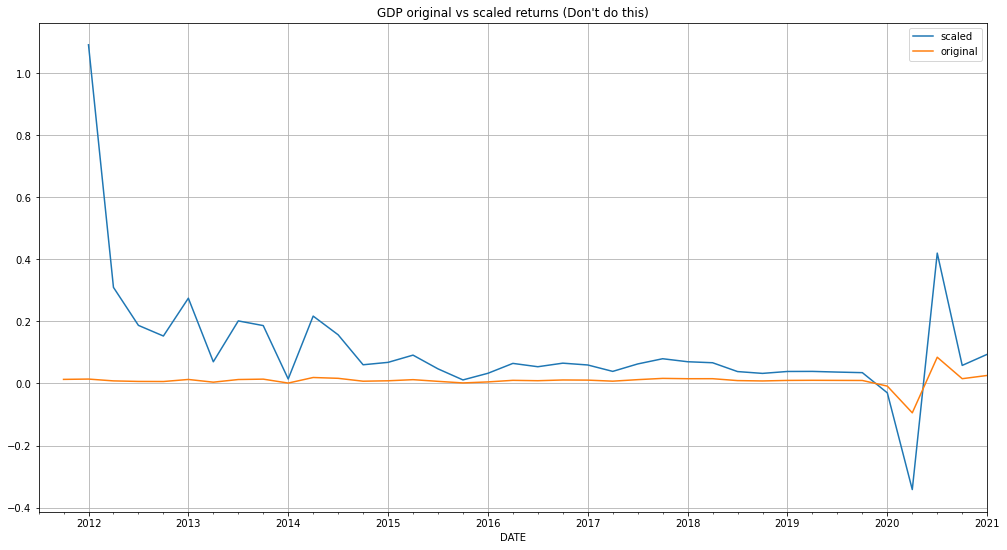

In [9]:
gdp_scaled['pct_change'] = gdp_scaled.pct_change().dropna()
gdp['pct_change'] = gdp['GDP'].pct_change().dropna()

gdp_returns = pd.DataFrame()
gdp_returns['scaled'] = gdp_scaled['pct_change']
gdp_returns['original'] = gdp['pct_change'] 
gdp_returns.plot(figsize = (17,9), title = "GDP original vs scaled returns (Don't do this)")
plt.grid(True)

We can see when we scale it makes the peaks and troughs different.

In [10]:
#let's look at the correlation, first start by combining and we'll drop the returns
gdp_combine = gdp.drop(columns = ["pct_change"])
cpi_combine = cpi.drop(columns = ["pct_change"])

In [11]:
#now combine them 
combine = pd.concat([gdp_combine, cpi_combine], axis = 1)
combine = combine.dropna()
combine.head()

,GDP,CPIAUCSL
DATE,,
2011-07-01,15591.850,225.395
2011-10-01,15796.460,226.750
2012-01-01,16019.758,227.842
2012-04-01,16152.257,229.187
2012-07-01,16257.151,228.590


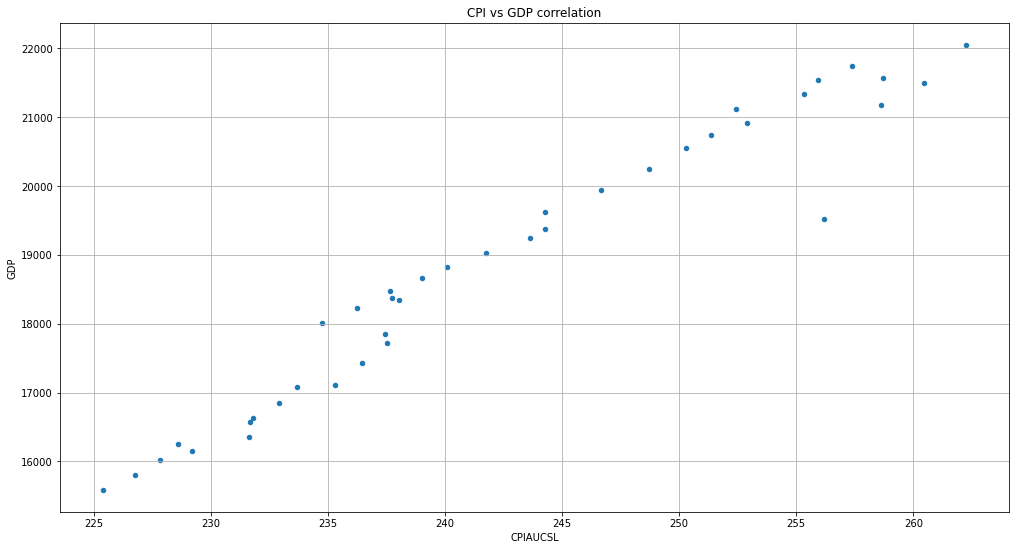

In [12]:
#now plot correlation
combine.plot(kind = 'scatter', x = 'CPIAUCSL', y = 'GDP', figsize = (17,9), title = "CPI vs GDP correlation")
plt.grid(True)

Ultimately we can see the positive correlation, although something to keep in mind is that CPI and GDP get quoted at different rates so when we combined the two dataframes we only kept values that shared the same date, making it all quarterly. This statistical test works but it is a little undesirable, the work around would be to go further back in time and take more data samples. Although older trends tend to fade out as time progresses. For this problem I would keep in mind that debt cycle works on a 100Y and 30Y process

I originally got this debt cycle from a Ray Dalio article you can find at this link
https://www.marketplace.org/2018/09/25/dalio-debt-cycle/

Another method would be to make a rolling correlation plot for a series of days, but due to a lack of data points its not very effective, but it is useful

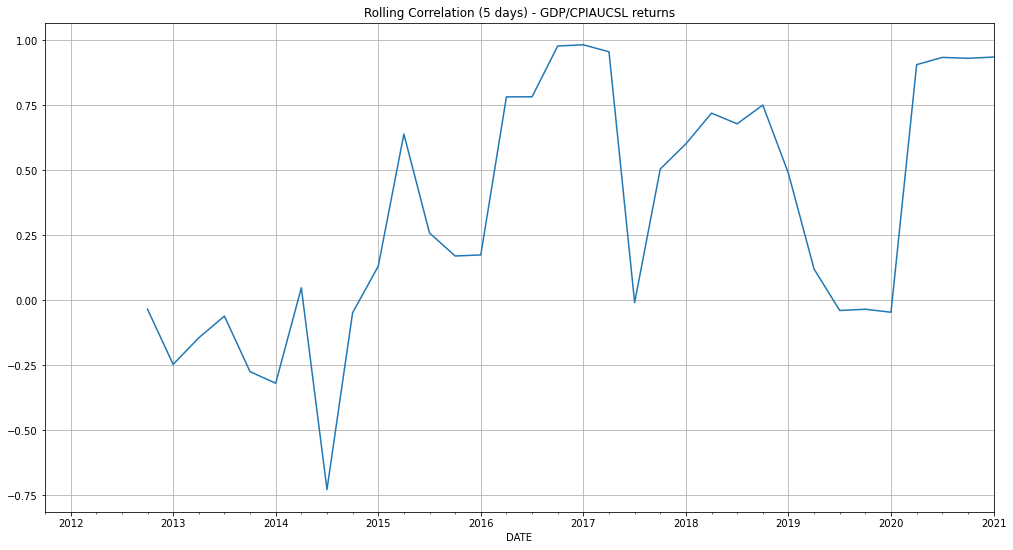

In [13]:
combine = combine.pct_change().dropna()
combine['GDP'].rolling(5).corr(combine['CPIAUCSL']).plot(figsize = (17,9))
plt.title("Rolling Correlation (5 days) - GDP/CPIAUCSL returns")
plt.grid(True)

Another problem that occurs is that the time series are usually nonstationary it won't have correlation but when we take the returns it makes the time series stationary, and comparing the returns making it look like there is positive correlation. It is hard to show this example with our original data because there is a positive correlation with the quoted prices. But with randomly generated data I can prove my point.

In [14]:
#the trick is to draw from different random seeds

np.random.seed(25)
series_1 = np.random.normal(size = 10000)

np.random.seed(26)
series_2 = np.random.normal(size = 10000)

df = pd.DataFrame({"series_1":series_1, "series_2":series_2})

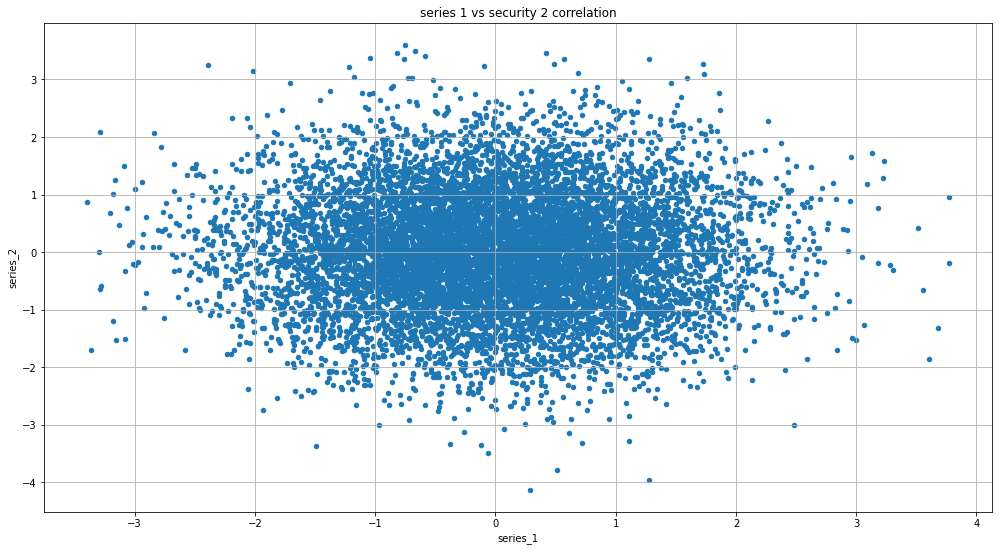

In [15]:
df.plot(kind = 'scatter', x = "series_1", y = "series_2", figsize = (17,9), 
        title = "series 1 vs security 2 correlation")
plt.grid(True)
plt.show()

In [16]:
#then if we add in these trends to simulate prices the correlation will look similar
intcp_1 = 10
intcp_2 = 150
trend = 0.15

df = pd.DataFrame({"series_1": series_1, "series_2": series_2}).assign(
    series_1 = lambda x: intcp_1 + (x.index * trend) + x['series_1'].cumsum(), 
    series_2 = lambda x: intcp_2 + (x.index * trend) + x['series_2'].cumsum())

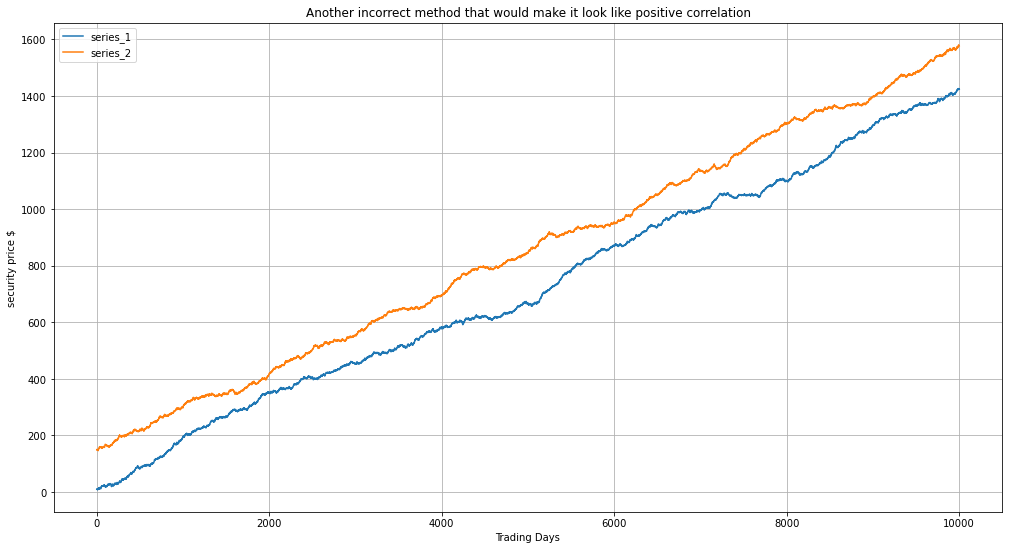

In [17]:
#then plot the results
def plot_results(df, sec_1, sec_2):
    
    #set up the axes
    ax = df[['series_1', 'series_2']].plot(figsize = (17,9))
    
    #then set the labels
    ax.set_xlabel("Trading Days")
    ax.set_ylabel("security price $")
    ax.set_title("Another incorrect method that would make it look like positive correlation")
    
    return ax

plot_results(df, 'series_1', 'series_2')
plt.grid(True)

You can see that it now looks like there is positive correlation although there isn't. 